AIm: 
- explore data to refine questions about data
- search for answers by visual comparisons and transformations


In [585]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

# import plotly.express as ex
# import plotly.graph_objs as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mplleaflet as mpl



pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')



<Figure size 2000x1000 with 0 Axes>

In [586]:
#t = gpd.read_file("../input_survey_data/jonas.geojson")
#t = pd.DataFrame(t)
#t.to_csv("../input_survey_data/jj.csv",index=True, mode='w')

In [587]:
# load raw survey data

raw_data = pd.read_excel("../input_survey_data/all-attributes_shophouses.xlsx")
raw_data.head(5);

In [588]:
## filter for most recent and serous flood hazards (2018/2019)

raw_data.tail(5)
#raw_data.filter(regex=r'^P1Q3', axis=1)  # P1 = first section, second block of questions, 


,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

#### Define targets

In [589]:
## small test set with preselection

df_p125 = raw_data#.filter(regex=r'Q0.7|P1Q3.11.1|^P1|^P5|GPS', axis=1)   # P1 = first section, second block of questions, 
## _r = most recent flood , _s = most serious flood
df_p125.insert(0, "Target_direct_r", df_p125.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
df_p125.insert(1, "Target_direct_s", df_p125.pop("P1Q5.6.2"))
#df_p125.insert(1, "Target_c", df_p125.pop("P1Q5.6.1"))  # target var for indirect cost due to business interuptions
df_p125.insert(2, "business_reduction_r", df_p125.pop("P1Q5.9.1"))  # explanatory var: monthly reduction of business [%] -> probl influences mainly economic damage costs
df_p125.insert(3, "business_reduction_s", df_p125.pop("P1Q5.9.2"))

df_p125.tail(2)



C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\3862214761.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p125.insert(0, "Target_direct_r", df_p125.pop("P1Q5.6.1"))  # target var for direct cost on content loss [VND]
C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\3862214761.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p125.insert(1, "Target_direct_s", df_p125.pop("P1Q5.6.2"))
C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\3862214761.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.7.2,P1Q5.8.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implemen

## Data cleaning 

In [590]:
#s1.combine(s2, max)
df = pd.DataFrame()

## filter for most serious flood and group replied choices in one col
df_p125_t = df_p125.filter(regex=r'^P1Q3.[2-7].2', axis=1)  # 3.2-3.7+3.88 (walls, floor)	What was the damage to your house/business building because of the flood
df['ColumnA']  =  df_p125_t[df_p125_t.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(str)),  axis=1)
df

#df_p125[df_p125.columns[1:]].apply(lambda x: ','.join(x.dropna().astype(str)),  axis=1)
  # P1 = first section, second block of questions, 
#P1Q6.4.2.3  # Q about 2 events, and selected choice "3"

,ColumnA
0,"2,3,1,1,98"
1,"4,1,4,1,98"
2,"3,1,3,1,98"
3,"3,1,1,1,98"
4,"1,1,1,1,98"
...,...
247,"2,1,1,1,98"
248,"1,1,1,1,98"
249,"2,1,1,1,98"
250,"3,1,1,1,98"


##### rename columns

In [591]:
## rename certain important columns

df_p125.rename(columns={#'P1Q3.11.1':'TARGET', # = total_costs_damage
                     'P1Q2.3.2':'inundation_duration_h',
                     'P1Q2.4.2':'water_depth_cm',
                     
                     'P1Q2.5.1':'contaminations',
                     'P1Q2.9.2':'warning_time_h',
                     'P1Q2.10.1.*':'emergency_measures', # bis .9, .88 ,.99 , .specify
                     'P1Q2.11.1.*':'overall_problem_house',
                     'P1Q3.2.1':'damage_level_floor',
                     'P1Q3.3.1':'damage_level_walls',
                     'P1Q3.4.1':'damage_level_foundation',
                     'P1Q3.5.1':'damage_level_doors',
                     'P1Q3.6.1':'damage_level_roof',
                     'P1Q3.7.1':'damage_level_basement',
                     'P1Q3.88.1':'damage_level_other',
                     'P1Q3.88.1':'damage_level_specify',
                     'P1Q3.8.1':'repair_costs_building_VND',
                     'P1Q3.11.1':'repair_costs_building_complete',

                    'P1Q5.1.1':'shp_flood_event',  # = recent or Q5.1.2?=most serious
                     'P1Q5.2.2':'shp_damage_level_furniture',
                     'P1Q5.3.2':'shp_damage_level_electronics',
                     'P1Q5.4.2':'shp_damage_level_business',
                     'P1Q5.5.2':'shp_damage_level_products',
                     'P1Q5.88.2':'shp_damage_level_others',
                     'P1Q5.6.2':'shp_total_direct_loss_content',
                     'P1Q5.7.2':'shp_closed_d',
                     'P1Q5.8.2':'shp_duration_back2normal',
                     'P1Q5.9.2':'shp_monthly_business_reduced_duringFlood',

                     'P2Q1.1.1':'protect_valuables',
                     'P2Q1.2.1':'water_barries',
                     'P2Q1.3.1':'pumping_equipment',
                     'P2Q1.4.1':'elevation_building',
                     'P2Q1.5.1':'resistant_material_building',
                     'P2Q1.6.1':'electricity_higher',
                     'P2Q1.7.1':'flood_protections',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2.1':'elevation_building_height_cm',
                     'P2Q2.3.1':'elevation_building_elements',

                     'P3Q1.1.1':'city_protection',
                     'P3Q1.2.1':'more_future_affected',
                     'P3Q1.3.1':'government_warnings',
                     'P3Q1.4.1':'government_careing',

                     'P4Q1.1':'household_inhabitants_number',
                     'P4Q1.8':'household_education',
                     'P4Q1.10':'household_income_aviable_monthly_mVND',
                     'P4Q2.1':'building_movingin',
                     'P4Q2.2':'building_year', # check 3.
                     'P4Q2.3':'building_floorsize_m2',
                     'P4Q3.1':'building_foundation', # check 3.
                     'P4Q3.2':'building_floor',
                     'P4Q3.3':'building_wall',

                     'P4Q3.5':'building_doors',
                     'P4Q3.6':'building_elevation_rel2surrounding_cm', # check3.
                     'P4Q4.3':'building_renovation_elements',
                     'P4Q4.4':'building_renovation_reasons',
                     'P4Q4.5':'building_renovation_cost_mVND',

                     'P5Q1.1':'shp_position',
                     'P5Q1.2':'shp_established',
                     'P5Q1.3':'shp_sector', # check
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_mVND',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_benefits_last5years',
                     'P5Q1.1':'shp_risk_behaviour',
                     'P5Q1.1':'shp_monetary_resources_prenvention'
 
                     }, inplace=True)

# P1Q7.1.1 and .2 = from whom recieved help
df_p125.head(3)

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,damage_level_floor,damage_level_walls,damage_level_foundation,damage_level_doors,damage_level_roof,damage_level_basement,damage_level_specify,P1Q3.88.1.specify,repair_costs_building_VND,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,repair_costs_building_complete,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,inundation_duration_h,water_depth_cm,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,warning_time_h,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_business,shp_damage_level_products,shp_damage_level_others,P1Q5.88.2.specify,shp_closed_d,shp_duration_back2normal,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4

#### fix non-integers to nan in numeric cols


In [592]:
## set all non-integers to nan 

# fix inundation duration and convert to integer
df_p125.inundation_duration_h = df_p125.inundation_duration_h.astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan))
df_p125.inundation_duration_h = df_p125.inundation_duration_h.astype(float).astype(pd.Int64Dtype())
df_p125.inundation_duration_h

0      2
1      2
2      3
3      5
4      3
      ..
247    4
248    3
249    5
250    3
251    1
Name: inundation_duration_h, Length: 252, dtype: Int64

#### Summarize variables into larger groups

In [544]:
## group variables into larger groups

flood_related = df_p125.filter(regex=r'P1Q2', axis=1) 
warnings_before = df_p125.filter(regex=r'P1Q2\.[>8]', axis=1)   # actually only 8-10 important
business_contents = df_p125.filter(regex=r'P1Q3', axis=1) 
# df_p125.filter(regex=r'^P1Q3.[2-7].2', axis=1)  #damages levels on building parts for most serious flood
received_help = df_p125.filter(regex=r'P1Q7', axis=1) 

precaution_measures = df_p125.filter(regex=r'P2Q1', axis=1) 
building_elevation = df_p125.filter(regex=r'P2Q2', axis=1) 
insurances = df_p125.filter(regex=r'P2Q3', axis=1) 

resilience_vulnerabilty = df_p125.filter(regex=r'P3Q1', axis=1) 
floods_past_future = df_p125.filter(regex=r'P3Q2', axis=1) 
floods_scenarios = df_p125.filter(regex=r'P3Q3', axis=1) 

household_profile = df_p125.filter(regex=r'P4Q1', axis=1) 
building_situation = df_p125.filter(regex=r'P4Q2', axis=1)  # floor size, building age, moved-in
building_structure = df_p125.filter(regex=r'P4Q3', axis=1)   # type of walls, etc
building_renovations = df_p125.filter(regex=r'P4Q4', axis=1)
househod_contents = df_p125.filter(regex=r'P4Q5', axis=1)  # PC, mobile phone, refigreator, bicycle

business_profile = df_p125.filter(regex=r'P5Q1', axis=1)  # business type, owner/employee




## Exploratory data analysis


### Map spatial distribution GPS

In [481]:
## get coords in reabalbe format for gpd
df_p125["lat"] = np.nan
df_p125["lon"] = np.nan

for coord_pair in range(0,len(df_p125)):
    try:
        df_p125["lon"][coord_pair] = [float(s) for s in df_p125["GPS"][coord_pair].split(",")][0]
        df_p125["lat"][coord_pair] = [float(s) for s in df_p125["GPS"][coord_pair].split(",")][1]
    except:  # if no coordiantes exists
        pass


df_p125 = gpd.GeoDataFrame(
    df_p125, geometry=gpd.points_from_xy(df_p125.lat, df_p125.lon)
    )
df_p125 = df_p125.drop(columns=['lat', 'lon', 'GPS'])

df_p125.head(1)

C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\1201307435.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p125["lat"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\1201307435.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p125["lon"] = np.nan
C:\Users\Anna\AppData\Local\Temp\ipykernel_14104\1201307435.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,Target_direct_r,Target_direct_s,business_reduction_r,business_reduction_s,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,damage_level_floor,damage_level_walls,damage_level_foundation,damage_level_doors,damage_level_roof,damage_level_basement,damage_level_specify,P1Q3.88.1.specify,repair_costs_building_VND,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,repair_costs_building_complete,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,inundation_duration_h,water_depth_cm,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,warning_time_h,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_business,shp_damage_level_products,shp_damage_level_others,P1Q5.88.2.specify,shp_closed_d,shp_duration_back2normal,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4

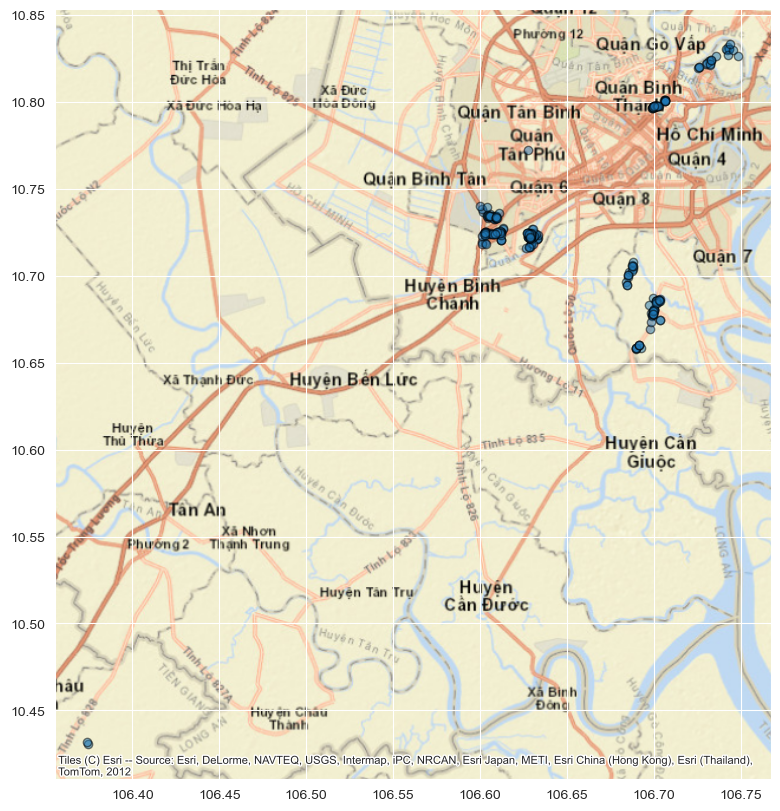

In [482]:
df_coords = df_p125.set_crs("EPSG:4326")
#df_coords_2 = df_coords.to_crs(epsg=3857)

ax = df_coords["geometry"].plot(figsize=(10, 10), alpha=0.5, edgecolor="k") # cx default needs epsg=3857  .to_crs('EPSG:3857').
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.WorldStreetMap)#, zoom=15) #,crs='EPSG:4326')#,  , source=cx.providers.TomTom.Basic)  .MapTiler.
                         
#mpl.display(fig=ax.figure, crs=df_coords_2.crs)


### examine data distribution of variabels
- types of businesses = DOONE
- water depth and inundation duration
- educational level
- distribution and amount of obs for business disruptions [monthly reduction %] P1Q5.9
- target 1 : direct costs of losses for business contents [VND]


#### flood related variables

In [545]:
# flood_related
floods_nbr = df_p125.filter(regex=r'^P1Q1.*', axis=1)
floods_nbr
floods_name_rs = flood_related.filter(regex=r'^P1Q2.1\.*', axis=1)
floods_name_rs
floods_time_rs = flood_related.filter(regex=r'^P1Q2.2\.*', axis=1)
floods_duration_rs = flood_related.filter(regex=r'^P1Q2.3*', axis=1) # in hours
floods_waterdepth_rs = flood_related.filter(regex=r'^P1Q2.4*', axis=1)  # in cm
floods_contaminants_rs  = flood_related.filter(regex=r'^P1Q2.5*', axis=1)
floods_velocity_rs  = flood_related.filter(regex=r'^P1Q2.6*', axis=1)
floods_causes_rs  = flood_related.filter(regex=r'^P1Q2.7*', axis=1)


# xx = P1Q2.5.1.[0-4,88,99,specify]
# xx = P1Q2.7.1.[1-3,88,99,specify]
# xx = P1Q2.8.1.[1-10,99,specify]
# xx = P1Q2.10.1.[1-9,88,99,specify]
# x = P1Q2.11.1.[1-9,88,99,specify]


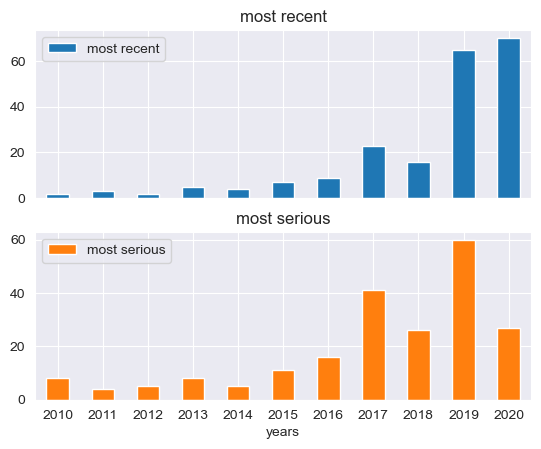

In [614]:

#floods_years_s = pd.to_datetime(floods_time_rs["P1Q2.2.2"], errors='ignore', format='mixed')
floods_years_r = floods_time_rs["P1Q2.2.1"].str.split(pat="/", expand=True)[2]  
floods_years_s = floods_time_rs["P1Q2.2.2"].str.split(pat="/", expand=True)[2] 
floods_years_r = pd.to_datetime(floods_years_r).dt.strftime('%Y')
floods_years_s = pd.to_datetime(floods_years_s).dt.strftime('%Y')

floods_years_rs = pd.DataFrame({"most recent": floods_years_r.value_counts(),
       "most serious": floods_years_s.value_counts()})
floods_years_rs.index.name = "years"
floods_years_rs

ax = floods_years_rs.plot.bar(rot=0, subplots=True)
ax[1].legend(loc=2) 

## TODO fix xls flood time row=[2,3]

In [617]:
floods_years_r.value_counts(),

(2
 2020    70
 2019    65
 2017    23
 2018    16
 2016     9
 2015     7
 2013     5
 2014     4
 2011     3
 2010     2
 2012     2
 Name: count, dtype: int64,)

In [660]:
water_depth_classes

,water_depth_cm
water_depth_cm,
"(0, 25]",80
"(25, 50]",113
"(50, 75]",35
"(75, 100]",20
"(100, 200]",4


Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


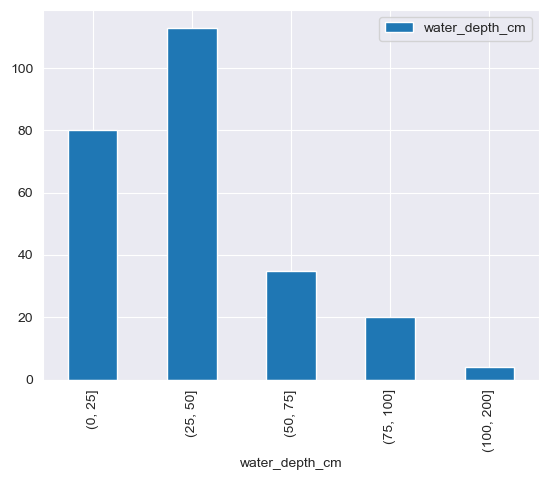

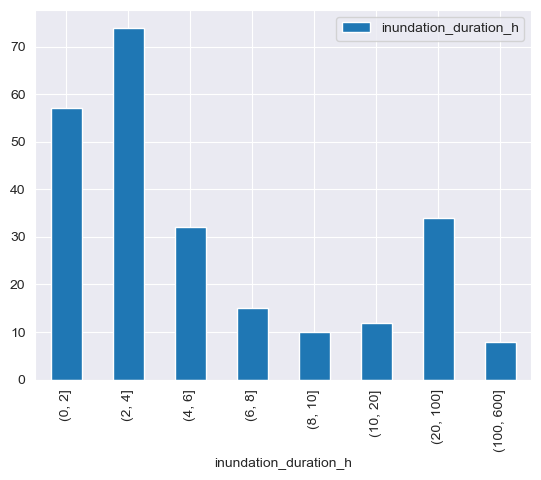

In [675]:
## floods_duration_rs and water depth 
df_p125[["inundation_duration_h","water_depth_cm"]]

## max duration = 600 h
## max waterdepth = 120 cm
inundation_duration_classes = df_p125['inundation_duration_h'].groupby(pd.cut(df_p125['inundation_duration_h'], [0, 2, 4, 6, 8, 10, 20, 100, 600])).count()
water_depth_classes = df_p125['water_depth_cm'].groupby(pd.cut(df_p125['water_depth_cm'], [0, 25, 50, 75, 100, 200])).count()
inundation_duration_classes = pd.DataFrame(inundation_duration_classes)
water_depth_classes = pd.DataFrame(water_depth_classes)

print(water_depth_classes.plot.bar())
print(inundation_duration_classes.plot.bar())

# fig, ax = plt.subplots(1, 2)
# ax[0].bar(x=water_depth_classes.index, y=water_depth_classes.water_depth_cm, height=4)
# ax[1].bar(x=water_depth_classes.index, y=water_depth_classes.water_depth_cm, height=4)




In [676]:
## business_contents
business_contents

,P1Q3.88.1.specify,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2
0,,0,0,1,0,0,0,0,0,0,0,,3,2,3,1,1,98,,,2,0,0,1,0,0,0,0,0,0,0,,100
1,,7,15,,,,,,,,,,4,4,1,4,1,98,,,100000000,7,15,,,,,,,,,,100
2,,0,0,0,0,0,1,0,0,0,0,,3,3,1,3,1,98,,,2,0,0,1,0,0,0,0,0,0,0,,200
3,,1,1,,,,,,,,,,2,3,1,1,1,98,,,300000,1,1,,,,,,,,,,300
4,,0,0,0,0,1,0,0,0,0,0,,2,1,1,1,1,98,,,2,0,0,0,0,1,0,0,0,0,0,,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,,1,2,,,,,,,,,,2,2,1,1,1,98,,,70000000,5,7,,,,,,,,,,100
248,,0,0,0,0,0,1,0,0,0,0,,1,1,1,1,1,98,,,2,0,0,0,0,0,1,0,0,0,0,,99
249,,0,0,0,0,1,0,0,0,0,0,,2,2,1,1,1,98,,,2,0,0,0,0,1,0,0,0,0,0,,99
250,,5,30,,,,,,,,,,3,3,1,1,1,98,,,120000000,5,30,,,,,,,,,,600


##### business_profile

In [ ]:
## precaution_measures


##### building_elevation

##### building_structure (eg  type of walls, etc), building_renovations

##### building_situation:  
- e.g floor size, building age, moved-in

#### floods_past_future

Further: insurances, resilience_vulnerabilty+floods_scenarios, household_profile, household_contents (e.g PC, mobile phone, refigreator, bicycl)

<Axes: >

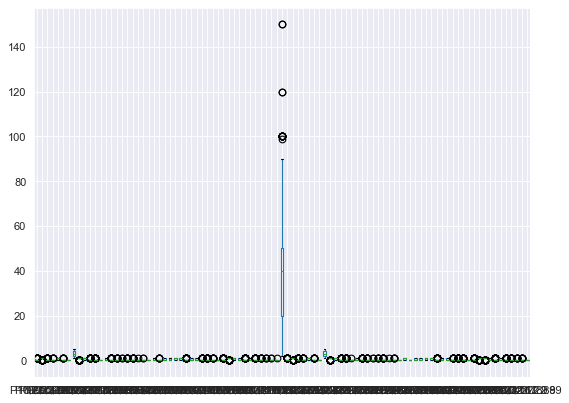

In [192]:
plt.figure(figsize=(8, 6), dpi=80)
flood_related.boxplot()#column=['business_reduction', 'inundation_duration_h', 'water_depth_cm'])

#### business types 
grouped by their parent sector


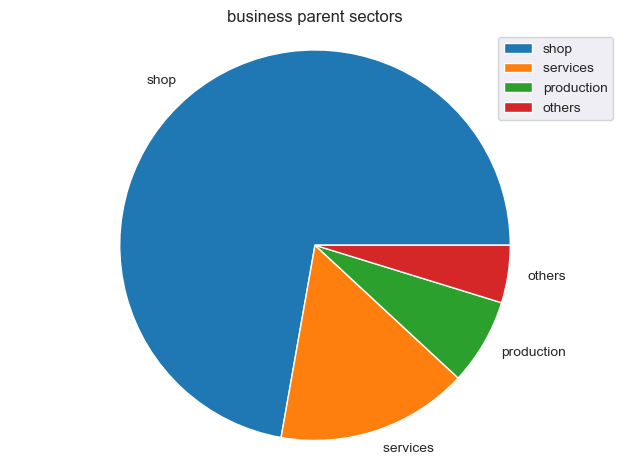

In [677]:
bins =  np.arange(10, 90, 10)  # business sectors
ind = np.digitize(df_p125['shp_sector'], bins)
 
shp_sectors = df_p125.shp_sector.groupby(ind).value_counts().reset_index(name='sector_freq')
shp_sectors = shp_sectors.groupby("level_0")['sector_freq'].sum().reset_index()
#shp_sectors.shp_sector = shp_sectors.shp_sector.replace([11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 31, 32, 33, 34, 35, 88],["food","fashion", "houseware"])

shp_sectors["sectors"] = shp_sectors.level_0.replace([1, 2, 3, 8],["shop", "services ", "production", "others"])

plt.pie(x="sector_freq", labels="sectors", data=shp_sectors)
plt.legend(shp_sectors.sectors, loc="best")
plt.title("business parent sectors")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### business types of shops

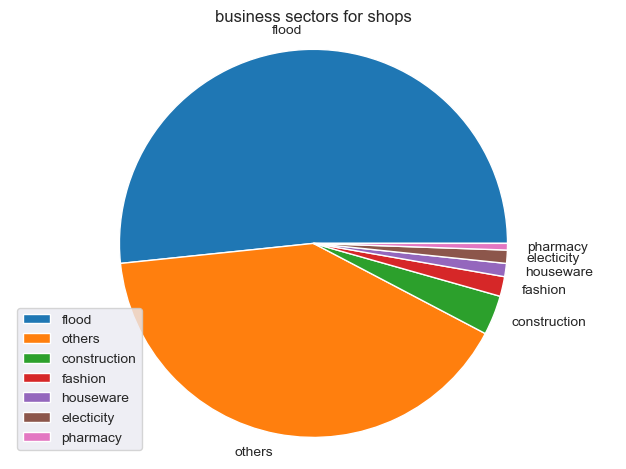

In [220]:
shop_types = df_p125.shp_sector[df_p125['shp_sector'] < 20]
#shop_types = df_p125[(df_p125['shp_sector'] >= 10) & (df_p125['shp_sector'] < 20)]
shop_types = shop_types.value_counts().reset_index(name='shop_freq')
shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["flood", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
plt.legend(shop_types.shop_type, loc="best")
plt.title("business sectors for shops")
plt.axis('equal')
plt.tight_layout()
plt.show()


#### business disruptions [monthly reduction %] P1Q5.9

## Correlation between variables by Pearson Correlation Coefficient

In [ ]:
sns.heatmap(df_p125.corr(), cmap="YlGnBu", annot=True)
#sns.heatmap(df_p125[['Age','Height','Weight']].corr(), cmap="YlGnBu", annot=True)

NameError: name 'sns' is not defined

In [ ]:
## further plotting types

# sns.pairplot(merged[['Age','Height','Weight']])
# sns.scatterplot(x='Height',y='Weight',hue="Sex",data=merged)

## categorize non-numeric variables

In [ ]:
df_p125["Target_c"].unique()  # VND

array([0, ',8', ',5', 50, 1, 40, 6, ',2', 2, 4, 99, 5, 15, 20, '1,5', 10,
       3, '3,2', 7, ',6', 30, ',7', '1,2', 280, 70, 6000, ',3', 700, 11,
       '7,5', '4,5'], dtype=object)

In [ ]:
df_p125

,Target_b,Target_c,business_reduction,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,inundation_duration_h,water_depth_cm,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,damage_level_floor,damage_level_walls,damage_level_foundation,damage_level_doors,damage_level_roof,damage_level_basement,damage_level_specify,P1Q3.88.1.specify,repair_costs_building_VND,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.7.1,P1Q5.8.1,P1Q6.4.1.1,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,shp_monetary_resources_prenvention,P5Q1.1.Specify,shp_established,shp_sector,P5Q1.3.Specify,shp_employees,shp_avgmonthly_sale_mVND,P5Q1.6.1,P5Q1.6.2,P5Q1.6.3,P5Q1.6.4,P5Q1.6.5,P5Q1.6.88,P5Q1.6.Specify,shp_capital_mVND,P5Q1.9.1,P5Q1.9.2,P5Q1.9.3,P5Q1.9.4,P5Q1.9.5,P5Q1.9.6,shp_benefits_last5years,P5Q1.11,P5Q1.12
0,100,0,0,5,,2015,99/99/2015,2,10,1,0,0,0,0,0,0,,2,1,0,0,0,0,,1,0,0,0,0,0,0,0,0,0,0,,3,0,0,0,0,0,0,0,0,1,0,0,,0,0,0,0,0,1,0,0,0,0,0,,3,2,3,1,1,98,,,2,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,3,,2010,17,S?a qu?n áo c?,1,2,1,0,0,0,0,0,,5,1,0,0,0,0,0,4,1,1
1,100,0,0,5,,2023-09-17 00:00:00,09/99/2017,2,15,0,1,0,0,0,0,0,,2,1,1,0,0,0,,0,0,0,0,0,0,0,0,0,1,0,,,0,0,0,0,0,0,0,0,1,0,0,,0,0,0,0,0,0,1,0,0,0,0,,4,4,1,4,1,98,,,100000000,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,3,,2019,22,,1,2,1,0,0,0,0,0,,10,0,1,0,0,0,0,4,1,1
2,99,0,0,5,,c?n m?a l?n tháng 8/2020,8/99/2020,1,2,1,0,0,0,0,0,0,,2,0,1,0,0,0,,0,0,0,0,0,0,0,0,0,1,0,,,0,0,0,0,0,0,0,0,1,0,0,,0,1,0,0,0,0,0,0,0,0,0,,1,1,1,1,1,98,,,2,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,1,,1999,31,,1,1,1,0,0,0,0,0,,10,1,0,0,0,0,0,3,1,1
3,500,0,99,3,,m?a l?n tháng 7/2020,7/99/2020,3,10,1,0,0,0,0,0,0,,1,0,1,0,0,0,,0,1,0,0,0,0,0,0,0,0,0,,8,0,0,0,0,0,0,0,0,1,0,0,,0,1,1,1,0,0,0,0,0,0,0,,1,2,1,1,1,98,,,100000,1,1,1,1,,,1,1,0,0,0,0,0,0,0,1,0,,1,,2015,11,,1,1,1,0,0,0,0,0,,99,1,0,0,0,0,0,3,1,1
4,99,0,0,3,,tr?n m?a l?n tháng 7/2020,7/99/2020,3,5,0,1,0,0,1,0,0,,3,0,1,0,0,0,,0,0,0,0,0,0,0,0,0,1,0,,,0,0,0,0,0,0,0,0,1,0,0,,0,1,0,0,0,0,0,0,0,0,0,,2,1,1,1,1,98,,,2,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,1,,2014,11,,1,1,1,0,0,0,0,0,,1,1,0,0,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,100,0,99,5,,Ng?p 2019,10/99/2019,4,50,0,1,0,0,1,0,0,,1,1,0,0,0,0,,1,0,0,0,0,0,0,0,0,0,0,,99,1,0,1,0,0,1,0,0,0,0,0,,0,1,1,0,0,0,0,0,0,0,0,,2,2,1,1,1,98,,,5000000,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,1,,2014,17,V?t li?u xây d?ng,2,3,1,0,0,0,0,0,,300,1,1,0,0,0,0,4,3,3
248,99,0,0,4,,Ng?p 2019,09/99/2019,1,5,0,1,0,0,1,0,0,,1,1,0,0,0,0,,1,0,0,0,0,0,0,0,0,0,0,,99,1,0,1,0,0,0,0,0,0,0,0,,1,0,0,0,0,0,0,0,0,0,0,,1,1,1,1,1,98,,,2,1,1,1,1,,,0,0,0,0,0,0,0,0,0,1,0,,1,,2015,11,,2,3,1,0,0,0,0,0,,20,1,1,0,0,0,0,4,3,4
249,99,0,0,4,,Ng?p 2017,08/99/2017,5,20,0,1,0,0,1,0,0,,1,1,0,0,0,0,,1,0,0,0,0,0,0,0,0,0,0,,99,0,0,1,0,0,0,0,0,0,1,0,Xây kè xung quanh nhà,0,1,1,1,0,0,0,0,0,0,0,,2,2,1,1,1,98,,,2,1,1,1,1,,,0,0,,0,0,0,0,0,0,1,0,,3,,2005,11,,5,3,1,0,0,0,0,0,,300,1,1,1,0,0,0,2,1,2
250,600,2,0,4,,??t ng?p do tri?u c??ng dâng cao 2019,10/99/2019,3,5,0,1,0,0,1,0,0,,2,1,0,0,0

#########################

## ungepürfte col name conversions

                    'Q0.7': 'interviewer',
                    'P1Q5.1.1':'shp_flood_event',  # = recent or Q5.1.2?=most serious
                     'P1Q5.2.2':'shp_damage_level_furniture',
                     'P1Q5.3.2':'shp_damage_level_electronics',
                     'P1Q5.4.2':'shp_damage_level_business',
                     'P1Q5.5.2':'shp_damage_level_products',
                     'P1Q5.88.2':'shp_damage_level_others',
                     'P1Q5.6.2':'shp_total_direct_loss_content',
                     'P1Q5.7.2':'shp_closed_d',
                     'P1Q5.8.2':'shp_duration_back2normal',
                     'P1Q5.9.2':'shp_monthly_business_reduced_duringFlood',

                     'P2Q1.1.1':'protect_valuables',
                     'P2Q1.2.1':'water_barries',
                     'P2Q1.3.1':'pumping_equipment',
                     'P2Q1.4.1':'elevation_building',
                     'P2Q1.5.1':'resistant_material_building',
                     'P2Q1.6.1':'electricity_higher',
                     'P2Q1.7.1':'flood_protections',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2.1':'elevation_building_height_cm',
                     'P2Q2.3.1':'elevation_building_elements',

                     'P3Q1.1.1':'city_protection',
                     'P3Q1.2.1':'more_future_affected',
                     'P3Q1.3.1':'government_warnings',
                     'P3Q1.4.1':'government_careing',

                     'P4Q1.1':'household_inhabitants_number',
                     'P4Q1.8':'household_education',
                     'P4Q1.10':'household_income_aviable_monthly_mVND',
                     'P4Q2.1':'building_movingin',
                     'P4Q2.2':'building_year', # check 3.
                     'P4Q2.3':'building_floorsize_m2',
                     'P4Q3.1':'building_foundation', # check 3.
                     'P4Q3.2':'building_floor',
                     'P4Q3.3':'building_wall',

                     'P4Q3.5':'building_doors',
                     'P4Q3.6':'building_elevation_rel2surrounding_cm', # check3.
                     'P4Q4.3':'building_renovation_elements',
                     'P4Q4.4':'building_renovation_reasons',
                     'P4Q4.5':'building_renovation_cost_mVND',

                     'P5Q1.1':'shp_position',
                     'P5Q1.2':'shp_established',
                     'P5Q1.3':'shp_sector', # check
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_mVND',
                     'P5Q1.6':'shp_finance_investments',
                     'P5Q1.7':'shp_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_benefits_last5years',
                     'P5Q1.1':'shp_risk_behaviour',
                     'P5Q1.1':'shp_monetary_resources_prenvention'